# Lorenz96
For a number of variables $ J \in \mathbb{N} $, external force $ F \in \mathbb{R} $ and state variable $ \mathbb{x} \in \mathbb{R}^J $ on 1D periodic domain, the Lorenz 96 equation (Lorenz 1996) is given by

$$ \frac {dx_{i}}{dt} =(x_{i+1}-x_{i-2})x_{i-1}-x_{i}+F, $$

with $ x_{-1} = x_{J-1} $, $ x_0 = x_N $, and $ x_{N+1} = x_1 $.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from da.l96 import lorenz96
from da.scheme import rk4
from da.loss import loss_rms
from da.visualize import plot_loss
from da.etkf import ETKF

In [5]:
# Lorenz96
# J: dim of state space
J = 40

# F: forcing
F = 8


In [6]:
# generate data
# dt: time step size
dt = 0.01

# N: number of time step, 2 years : 360*20*2
N = 360*20*2 

# initial state near the statinary point
x0 = F*np.ones(J) # the statinary point
x0[19] *= 1.001 # perturb

# use my modules
scheme = rk4
p = (F, )

result = np.zeros((N,len(x0)))
x = x0
result[0] = x[:]

for n in range(1,N):
    t = n*dt
    x = scheme(lorenz96, t, x, p, dt)
    result[n] = x[:]


x_true = result[360*20:][::5] # spin up 1 year and save per 6 hours
print(x_true.shape)
np.save(f"x_true_l96", x_true)

(1440, 40)


In [7]:
# assimilation period
Dt = 0.05

# Model function for EnKF
def M(x, Dt):
    for i in range(int(Dt/0.01)):
        x = rk4(lorenz96, 0, x, p, 0.01)
    return x

# 観測
H_diag = np.ones(J)
# H_diag[::2] = 0
H = np.diag(H_diag)
# H[:, :10] = 0
# dim_y = 30
# H = np.zeros((dim_y, J))
# H[::4, ::4] = 0
print("diag of H", H_diag)
print("rank(H)", np.linalg.matrix_rank(H))

# Model error covariance
Q = np.zeros((J, J))

# Observation error covariance
r = 1.0
R = r*np.eye(J)

# random seed
seed = 0
np.random.seed(seed)

# generate observation
end_step = 500 # for development
x_true = np.load('x_true_l96.npy')[:end_step]
# y = np.load('x_obs_l96.npy')[:end_step]
# if not np.isclose(r, 1.0):
y = (H@x_true.T).T
y += np.random.normal(loc=0, scale=np.sqrt(r), size=y.shape) # R = r*I

# initial state for EnKF
x_0 = x_true[np.random.randint(len(x_true)-1)]

P_0 = 25*np.eye(J)

# ensemble size
# m = 41

# deterministic ensemble
m = J+1
X_0 = np.zeros((J+1, J))
for i in range(J+1):
    if i == J:
       e = X_0[:J].sum(axis=0)
       X_0[J] = e
    else:
        e = np.zeros(J)
        e[i] = 1
        X_0[i] = e
X_0 *= 1
# inflation
alpha = 1.5

diag of H [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
rank(H) 40


<BarContainer object of 40 artists>

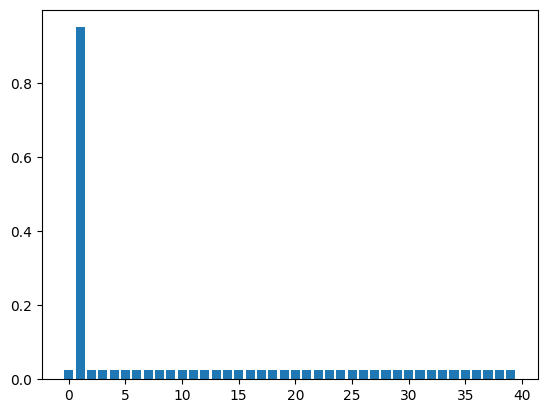

In [8]:
# eigen values of initial cov
dX_0 = X_0 - X_0.mean(axis=0, keepdims=True)
P_0 = dX_0.T @ (dX_0) / (J-1)

plt.bar(np.arange(J), np.linalg.eigvals(P_0))

## $\alpha$ vs. $ \log(\hat{\lambda}_{min}) $

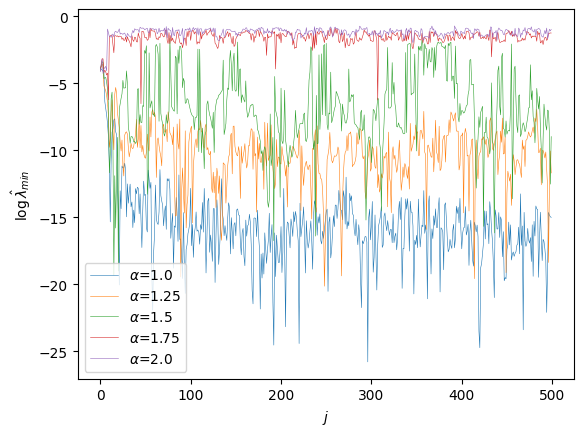

In [13]:
import scipy as sp
alpha_list = [1.0, 1.25, 1.5, 1.75, 2.0]

evals_alpha = []
xa_alpha = []
for alpha in alpha_list:
    etkf = ETKF(M, H, R, alpha=alpha, store_ensemble=True)
    etkf.initialize(X_0)
    for y_obs in y:
        etkf.forecast(Dt)
        etkf.update(y_obs)

    xa_alpha.append(etkf.x)

    Pf = []
    for X in etkf.X_f:
        dX = X - X.mean(axis=0, keepdims=True)
        P = dX.T @ (dX) / (J-1)
        Pf.append(P)
    evals = np.array([sp.linalg.eigvals(Pf_t).real for Pf_t in Pf])
    evals_alpha.append(evals)


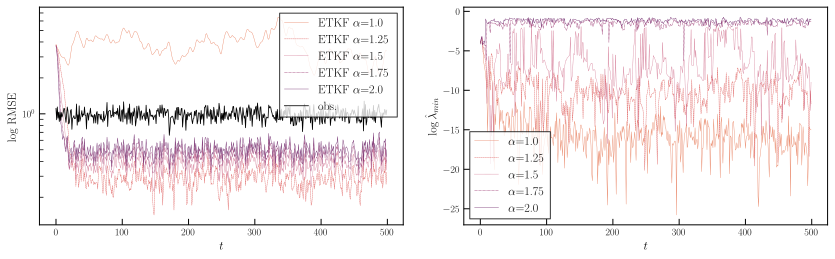

In [53]:
from visualize import get_color_palette, get_linestyle_cycle, get_marker_cycle
# Plot
fig, axes = plt.subplots(1, 2, figsize=(12,4))

num_alpha = len(alpha_list)
colors = get_color_palette(num_alpha, "flare")
line_cycle = get_linestyle_cycle()
# marker_cycle = get_marker_cycle()
for i, xa in enumerate(xa_alpha):
    alpha = alpha_list[i]
    evals = evals_alpha[i]

    c = colors[i]
    ls = next(line_cycle)
    # m = next(marker_cycle)
    plot_loss(x_true, xa, loss_rms, ax=axes[0], label=f"ETKF $\\alpha$={alpha}", lw=0.4, color=c, ls=ls)
    axes[1].plot(np.log(evals)[:, -1], label=f"$\\alpha$={alpha}", lw=0.4, color=c, ls=ls)
plot_loss((H@x_true.T).T, y, loss_rms, ax=axes[0], label='obs.', lw=0.8, c="k")

axes[0].set_xlabel("$t$")
axes[0].set_ylabel("log RMSE")
axes[0].set_yscale("log")
axes[0].legend(bbox_to_anchor=(1, 1), loc='upper right')
# axes[0].set_ylim([0,4])

axes[1].set_xlabel("$t$")
axes[1].set_ylabel("$\\log\\hat{\\lambda}_{min}$")
axes[1].legend()
fig.tight_layout()